This notebook provides an example of how to use the `poopy` package to access historical CSO discharge monitoring data provided by water companies.

First, we import the libraries we need.

In [1]:
from poopy.companies import ThamesWater

# To help demonstrate the package
import datetime
import os
import matplotlib.pyplot as plt

First we initiate an instance of a `WaterCompany` object. We opt to use the `ThamesWater` as an example. 

In [2]:
tw_clientID = os.getenv("TW_CLIENT_ID")
tw_clientSecret = os.getenv("TW_CLIENT_SECRET")

if tw_clientID is None or tw_clientSecret is None:
    raise ValueError(
        "Thames Water API keys are missing from the environment!\n Please set them and try again."
    )

tw = ThamesWater(tw_clientID, tw_clientSecret)

Initialising Thames Water object...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch


Initiating a `WaterCompany` object will automatically download the current status of all the monitors. What we want to do is explore historical information for past discharges. This can either be done at the level of the individual `Monitor` or at the level of the `WaterCompany`. Lets explore the former first using the "Bourton-On-The-Water" monitor.

In [3]:
monitor = tw.active_monitors["Bourton-On-The-Water"]
monitor.get_history()

Requesting historical data for Bourton-On-The-Water from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	No more records to fetch
	Building history for Bourton-On-The-Water...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-14T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(


Above, we ran the `get_history()` method that extracts the historical data for a given monitor. This information is stored in the `Monitor` object in the `history` attribute. This is a List of `Event` objects. For example, lets see what the fifth event in the history is. Recall that an `Event` object can either be a `Discharge`, `Offline` or `NoDischarge`. 

In [4]:
fifth_event = monitor.history[4]
fifth_event.print()


        
        --------------------------------------
        Event Type: Not Discharging
        Site Name: Bourton-On-The-Water
        Permit Number: CTCR.2036
        OSGB Coordinates: (417620, 219070)
        Receiving Watercourse: Groundwater
        Start Time: 2024-05-04 19:45:00
        End Time: 2024-05-05 09:00:00
        Duration: 795.0 minutes
        


To visualise the history once it has been calculated we can use the `plot_history()` method. This will plot the history of the monitor as a 'barcode', the colour of the bar corresponds to the status of the event through time. Brown is a discharge, grey is offline and white is no discharge. Note that the barchart automatically goes back as far as the first recorded discharge or offline event for that monitor. 

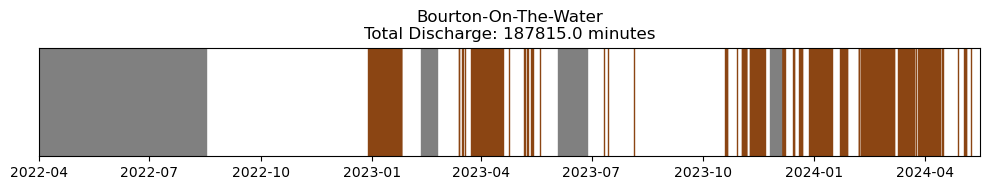

In [5]:
monitor.plot_history()

We can make it plot for a shorter period by passing a `since` parameter. For example, lets look at only the last 3 months.

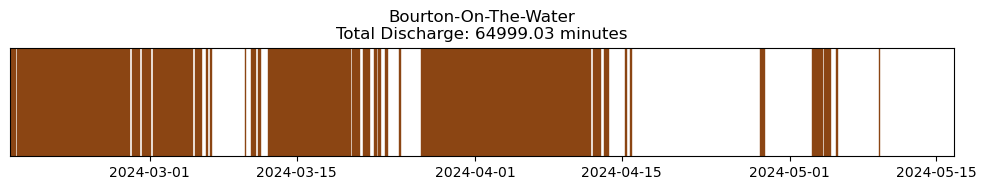

In [6]:
since_3_months = datetime.datetime.now() - datetime.timedelta(days=90) # 90 days = 3 months
monitor.plot_history(since=since_3_months)

We can print out some summary information about the total amount of discharge as follows:

In [7]:
print(f"Total discharge: {monitor.total_discharge()} minutes")
print(f"Total discharge last 12 months: {monitor.total_discharge_last_12_months()} minutes")
print(f"Total discharge last 6 months: {monitor.total_discharge_last_6_months()} minutes")
print(f"Total discharge since start of year: {monitor.total_discharge_since_start_of_year()} minutes")
print(f"Total discharge last 3 months: {monitor.total_discharge(since=since_3_months)} minutes")

Total discharge: 187815.0 minutes
Total discharge last 12 months: 122040.0 minutes
Total discharge last 6 months: 111289.02988823333 minutes
Total discharge since start of year: 98310.0 minutes
Total discharge last 3 months: 64999.03375231667 minutes


If we want to calculate the history for all monitors managed by a particular water company we can do this by calling the `set_all_histories()` method on the `WaterCompany` object. This sets the `history` attribute of all the monitors in the `WaterCompany` object.

In [8]:
tw.set_all_histories()

Requesting historical data for all monitors from Thames Water API...
	Requesting historical events since 2022-04-01 00:30:00...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=2000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=3000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=4000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=5000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=6000
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/S

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Abbey Mills contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-05-13T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Abbey Mills contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-05-02T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Abbey Mills contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-05-02T08:15:00. Skipping that entry...
  warnings.warn(


	Building history for Aldershot Town...
	Building history for Alicia Avenue CSO...
	Building history for Allendale Road...
	Building history for Alperton Lane...
	Building history for Amersham Balancing Tanks/Amersham Vale STK...
	Building history for Ampney St Peter...
	Building history for Amyand Park Road, Twickenham...
	Building history for Andoversford...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-04-29T09:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-04-29T09:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Amersham Balancing Tanks/Amersham Vale STK contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-17T23:45:00. Skipping that e

	Building history for Appleton...
	Building history for Arborfield...
	Building history for Arford...
	Building history for Ascot...
	Building history for Ash Ridge (Wokingham)...
	Building history for Ash Vale...
	Building history for Aston Le Walls...
	Building history for Auckland Road Storm Tanks...
	Building history for Avon Dassett...
	Building history for Avondale Rd...
	Building history for Aylesbury...
	Building history for Bakers Farm, High Wych...
	Building history for Bampton...
	Building history for Banbury...
	Building history for Banbury Rd Middleton Cheney...
	Building history for Bancroft Rugby Ground, Buckhurst Hill...
	Building history for Barbers Lane...
	Building history for Barkway...
	Building history for Basingstoke...
	Building history for Beckley...
	Building history for Beckton...
	Building history for Beddington...
	Building history for Beech Hall Crescent, Walthamstow...
	Building history for Beenham...
	Building history for Beer Lane...
	Building history f

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-14T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bourton-On-The-Water contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-08T13:45:00. Skipping that entry...
  warnings.warn(


	Building history for Box Hill...
	Building history for Boyne Avenue, Hendon...
	Building history for Bracknell...
	Building history for Bramley...
	Building history for Brent Cross Flyover...
	Building history for Brent Valley Golf Course, LB Ealing...
	Building history for Brentfield Gardens...
	Building history for Brickendon...
	Building history for Bridle Close, Ewell...
	Building history for Brixton Storm Relief Sewer...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-02-08T14:32:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-11T09:22:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Brixton Storm Relief Sewer contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-11T09:22:00. Skipping that entry...
  warnings.warn(


	Building history for Broadwell...
	Building history for Brockham Bridge...
	Building history for Brook Way, Chigwell...
	Building history for Broome (Attenuation Tank)...
	Building history for Bucklebury (Briff Lane)...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bucklebury (Briff Lane) contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-11-07T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bucklebury (Briff Lane) contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-28T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Bucklebury (Briff Lane) contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-28T09:30:00. Skipping that entry...
  warnings.warn(


	Building history for Bucknell...
	Building history for Buntingford...
	Building history for Burford...
	Building history for Burghfield...
	Building history for Burstow...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Burghfield contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-03-06T16:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Burghfield contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-02-08T05:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Burghfield contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-02-08T05:45:00. Skipping that entry...
  warnings.warn(


	Building history for Bushey Court, Raynes Park...
	Building history for Bute Street CSO...
	Building history for Byfield...
	Building history for Caddington...
	Building history for Cage End, Essex...
	Building history for Camberley...
	Building history for Canfield End, Little Canfield...
	Building history for Canfold Wood...
	Building history for Canterbury Road, Thornton Heath...
	Building history for Capel...
	Building history for Carlton Cres Jnc Blenheim Cres...
	Building history for Carterton...
	Building history for Cascade Road Storm Tanks, Buckhurst...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Canfield End, Little Canfield contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-05-05T06:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Canfield End, Little Canfield contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-03-22T11:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Canfield End, Little Canfield contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-03-22T11:00:00. Skipping that entry...
  warnings.warn(
/home/alex/ana

	Building history for Cassington...
	Building history for Castle Drive...
	Building history for Castle Gardens, Dorking...
	Building history for Chacombe...
	Building history for Chadlington...
	Building history for Chalgrove...
	Building history for Channelsea West Ham Lane PS ...
	Building history for Chapel Row (Berks)...
	Building history for Chapmore End...
	Building history for Charlbury...
	Building history for Charlton Storm Relief...
	Building history for Charlton-On-Otmoor...
	Building history for Charlwood, Surrey...
	Building history for Chelsea, London, Sw10...
	Building history for Chertsey...
	Building history for Chesham...
	Building history for Chieveley...
	Building history for Chigwell Road / Langston Road...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-15T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Chertsey contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companie

	Building history for Chigwell Road, Woodford Green...
	Building history for Chingford Storm Tanks...
	Building history for Chinnor...
	Building history for Chipping Norton...
	Building history for Chipping Warden...
	Building history for Chisledon Storm Tanks ...
	Building history for Chobham...
	Building history for Cholsey...
	Building history for Church Hanborough...
	Building history for Church Hill Road, Barnet...
	Building history for Church Road...
	Building history for Church Road/Brent Lodge Park (Bunny Park)...
	Building history for Church Street KT13 8DP...
	Building history for Church Street Sewer...
	Building history for Churt...
	Building history for Cirencester...
	Building history for Clanfield...
	Building history for Clapham Storm Relief Sewer, London...
	Building history for Clifton...
	Building history for Cobham Bridge, Adj Cobham PS...
	Building history for Codicote...
	Building history for Colgate...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Colgate contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-02-05T09:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Colgate contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-02-05T09:00:00. Skipping that entry...
  warnings.warn(


	Building history for Colin Crescent, Colindale...
	Building history for Combe...
	Building history for Commonside...
	Building history for Compton (Berks)...
	Building history for Conolly Road Hanwell...
	Building history for Coppice Green, Bracknell...
	Building history for Corbett Rd / Redbridge Lane, Wanstead...
	Building history for Cottered...
	Building history for Counters Creek, Lots Road...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-17T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cottered contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-13T22:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companie

	Building history for Craigton Road...
	Building history for Cranleigh...
	Building history for Crawley...
	Building history for Cricklade...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crawley contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-02-08T14:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crawley contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-02-08T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crawley contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-02-08T09:30:00. Skipping that entry...
  warnings.warn(


	Building history for Cricklewood Broadway...
	Building history for Cricklewood Lane, Cricklewood (A41 Hendon Way)...
	Building history for Crofton Road, Sunnydale...
	Building history for Crondall...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crofton Road, Sunnydale contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-20T09:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crofton Road, Sunnydale contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-02T19:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Crofton Road, Sunnydale contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-02T19:00:00. Skipping that entry...
  warnings.warn(


	Building history for Crooked Billet...
	Building history for Cropredy...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cropredy contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-03-20T12:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cropredy contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-03-15T08:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Cropredy contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-03-15T08:30:00. Skipping that entry...
  warnings.warn(


	Building history for Crossness...
	Building history for Cuddington...
	Building history for Culham...
	Building history for Culworth...
	Building history for Dagnall...
	Building history for Daintry Close...
	Building history for Dallow Road Jnc Lyndhurst Road...
	Building history for Darkes Lane, Potters Bar...
	Building history for Dartford Creek Storm...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dartford Creek Storm contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-06T03:00:00. Skipping that entry...
  warnings.warn(


	Building history for Dartnell Park, Byfleet...
	Building history for Deadmans Bridge...
	Building history for Dean Oak Lane...
	Building history for Deephams...
	Building history for Deptford Creek Storm...
	Building history for Deptford Storm Relief...
	Building history for Didcot...
	Building history for District Road...
	Building history for Dorchester...
	Building history for Dorking...
	Building history for Dorking Road...
	Building history for Dorton...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-09T10:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-02T02:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Dorchester contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-02T02:00:00. Skipping that entry...
  warnings.warn(


	Building history for Draycot Foliat...
	Building history for Drayton (Oxon)...
	Building history for Dunstable Road - Beech Road...
	Building history for Dunstable Road - Beech Road CSO 2...
	Building history for Dunstable Road - Francis Street...
	Building history for Duntshill Road...
	Building history for Earl...
	Building history for Earlswood (Reigate)...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Earl contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-02-01T12:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Earl contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-05-24T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Earl contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-05-24T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: Us

	Building history for Earlswood Common, S Of Pendleton Road...
	Building history for East Garston...
	Building history for East Grafton...
	Building history for East Lane CSO 1...
	Building history for East Lane CSO 2...
	Building history for East Shefford...
	Building history for Eastcote Avenue...
	Building history for Easthampstead Park...
	Building history for Edgware Road...
	Building history for Elmcroft Avenue, Wanstead...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Elmcroft Avenue, Wanstead contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-02-09T07:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Elmcroft Avenue, Wanstead contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-02-09T07:16:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Elmcroft Avenue, Wanstead contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-02-08T22:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/pytho

	Building history for Elms Road CSO...
	Building history for Elvetham Close...
	Building history for Empress Avenue ...
	Building history for Epping...
	Building history for Epsom Storm Tanks, Longmead Road...
	Building history for Esher...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Epping contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-25T23:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Epping contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-22T19:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Epping contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-22T19:15:00. Skipping that entry...
  warnings.warn(


	Building history for Essendon, Holywell Bridge...
	Building history for Ewhurst Road, Cranleigh, Surrey...
	Building history for Eydon...
	Building history for Fairfield Avenue 1...
	Building history for Fairfield Avenue 2...
	Building history for Fairford...
	Building history for Falcon Brook...
	Building history for Falloden Court & Brookland Rise...
	Building history for Faringdon...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Falloden Court & Brookland Rise contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-11-03T21:56:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Falloden Court & Brookland Rise contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-11-01T12:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Falloden Court & Brookland Rise contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-11-01T12:00:00. Skipping that entry...
  warnings.warn(


	Building history for Faringdon House CSO...
	Building history for Farnborough (Warks)...
	Building history for Farnham...
	Building history for Fergusson Road, Banbury...
	Building history for Field End Rd Storm (Harrow)...
	Building history for Field End Road (East)...
	Building history for Finstock...
	Building history for Fleet...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Fleet contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-01-19T11:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Fleet contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-29T18:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Fleet contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-29T18:00:00. Skipping that entry...
  warnings.warn(


	Building history for Fleet Main Line Sewer...
	Building history for Folkestone Rd Tanks, East Ham...
	Building history for Forest Hill...
	Building history for Francis Road Spill...
	Building history for Friday Street, Henley...
	Building history for Frogmore Storm...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-02T08:46:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-09-08T10:48:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Frogmore Storm contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-09-08T10:48:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packa

	Building history for Fulmer Drive CSO (Howards Wood Drive)...
	Building history for Fyfield (Wilts)...
	Building history for Gap Road (Cemetery)...
	Building history for Garden Way...
	Building history for Gascoigne Rd Storm Tanks, Beckton...
	Building history for George Street - King Street...
	Building history for George Street - Wellington Street...
	Building history for Gerrards Cross...
	Building history for Godalming...
	Building history for Gordon Road...
	Building history for Gordon Road (u205)...
	Building history for Goring...
	Building history for Goswell Street...
	Building history for Granville Road...
	Building history for Great Bedwyn...
	Building history for Greatworth...
	Building history for Greenwich...
	Building history for Grendon Underwood...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Greenwich contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-08-18T13:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Greenwich contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-08-18T11:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Greenwich contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-08-18T11:00:00. Skipping that entry...
  warnings.warn(


	Building history for Guildford...
	Building history for Gun Wharf (Wapping Dock)...
	Building history for Haddenham...
	Building history for Hadham Mill...
	Building history for Hambleden...
	Building history for Hammersmith...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-04-29T12:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-04-18T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hammersmith contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-04-18T08:15:00. Skipping that entry...
  warnings.warn(


	Building history for Hampstead Norreys...
	Building history for Hamstead Marshall...
	Building history for Hanger Lane...
	Building history for Hannington...
	Building history for Hanwell...
	Building history for Harpenden...
	Building history for Hartley Wintney...
	Building history for Haslemere...
	Building history for Haslemere STW CSO...
	Building history for Hatfield Heath...
	Building history for Hattchets Cricklade...
	Building history for Havelock Road Jnc Clarendon Road...
	Building history for Heath Wall PS...
	Building history for Henley...
	Building history for Henley Road...
	Building history for Heyford...
	Building history for High Road Loughton...
	Building history for High Road, Woodford...
	Building history for High Wycombe...
	Building history for Highfield Road Jct With Brookside Road...
	Building history for Highworth...
	Building history for Highworth Eastrop...
	Building history for Hillside Avenue...
	Building history for Hockford (Pirbright)...
	Building hist

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hogsmill contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-02-29T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hogsmill contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-02-05T09:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Hogsmill contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-02-05T09:15:00. Skipping that entry...
  warnings.warn(


	Building history for Holloway Storm Sewer...
	Building history for Holmwood...
	Building history for Holybourne...
	Building history for Home Park Road...
	Building history for Honeypot Lane...
	Building history for Hook Norton...
	Building history for Horley (Oxon)...
	Building history for Horley (Surrey)...
	Building history for Hornton...
	Building history for Horseferry Road...
	Building history for Horton-Cum-Studley...
	Building history for Huckers Lane (Selbourne)...
	Building history for Hull Green (Matching)...
	Building history for Hungerford...
	Building history for Hurstwood Road West...
	Building history for Iron Gate...
	Building history for Ironsbottom (Sidlow)...
	Building history for Isle Of Dogs, London...
	Building history for Islip...
	Building history for Iver (North)...
	Building history for Jews Row Pumping Station (Falconbrook Storm Relief)...
	Building history for Jnc Biscot Road - Lansdowne Road...
	Building history for Jnc Frederick Street & William Street..

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-06T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Knights Lane contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-12-21T05:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/po

	Building history for Leaden Roding...
	Building history for Leatherhead...
	Building history for Lechlade...
	Building history for Leopold Road, Church Path...
	Building history for Leverson Street...
	Building history for Lightwater...
	Building history for Lincoln Road CSO...
	Building history for Lindsay Drive, Falcon Way...
	Building history for Little Compton...
	Building history for Little Hallingbury...
	Building history for Little Marlow...
	Building history for Little Milton...
	Building history for Littlemead Ind Estate, Cranleigh...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-12T15:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Little Milton contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-19T11:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages

	Building history for Littlemore Low Level...
	Building history for London Bridge...
	Building history for London Road Near Hatherop Lane...
	Building history for London Road, Marlborough...
	Building history for Long Crendon...
	Building history for Long Reach...
	Building history for Longbridge Road...
	Building history for Longley Road (1), Tooting High Street...
	Building history for Longstone Ave, Drayton Road...
	Building history for Low Hall Farm Storm Tanks, Walthamstow...
	Building history for Low Level 1 N, Grosvenor Ditch, Millb...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Longbridge Road contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-11-01T08:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Longbridge Road contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-28T20:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Longbridge Road contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-28T20:00:00. Skipping that entry...
  warnings.warn(


	Building history for Lower Cherwell St, Banbury...
	Building history for Ludgershall...
	Building history for Luton...
	Building history for Lyon Park Avenue...
	Building history for Lytton Road SSO...
	Building history for Maidenhead...
	Building history for Main Road, Sidcup...
	Building history for Manor Drive Stormwater Tanks...
	Building history for Manor Farm...
	Building history for Maple Lodge...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-01-26T09:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-01-19T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Manor Drive Stormwater Tanks contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-01-19T10:00:00. Skipping that entry...
  warnings.warn(


	Building history for Mapleton Road...
	Building history for Markenfield Road, Guildford...
	Building history for Markyate...
	Building history for Marlborough...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Marlborough contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-02-15T18:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Marlborough contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-02-15T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Marlborough contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-02-15T10:00:00. Skipping that entry...
  warnings.warn(


	Building history for Marsh Gibbon...
	Building history for Marsh Lane Bridge, Taplow...
	Building history for Marston St Lawrence SPS...
	Building history for Marsworth...
	Building history for Mays Lane Overflow ...
	Building history for Melford Road, London, E11...
	Building history for Merstham...
	Building history for Middle Barton...
	Building history for Middleton Cheney...
	Building history for Middleton Stoney...
	Building history for Midgham...
	Building history for Mill Green (Hatfield)...
	Building history for Millbank, Crawley...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-11-14T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-28T06:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Middleton Cheney contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-28T06:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site

	Building history for Milton-Under-Wychwood...
	Building history for Mogden...
	Building history for Montrose Avenue/Blenheim Crescent...
	Building history for Moreton Pinkney...
	Building history for Moreton-In-Marsh...
	Building history for Moreton-In-Marsh (Primrose Court)...
	Building history for Mornington Crescent...
	Building history for Mortimer (Stratfield)...
	Building history for Mulberry Court, Hall Road...
	Building history for Nags Head Lane (Brentwood)...
	Building history for Ne Storm Relief Shadwell, King Edward Mem Park...
	Building history for Near Sezincote Lodge...
	Building history for Neasden Station...
	Building history for Netherlands Road CSO...
	Building history for New Bedford Road, Luton...
	Building history for New Mill (Eversley Lower Common)...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-12-04T12:38:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-12-01T09:32:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Ne Storm Relief Shadwell, King Edward Mem Park contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-12-01T09:32:00. Ski

	Building history for Newbury...
	Building history for Newmans Lane...
	Building history for Nightingale Lane...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-03-30T14:20:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-11-28T15:36:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Nightingale Lane contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-11-28T15:36:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site

	Building history for Norfolk Street...
	Building history for North End Road CSO...
	Building history for North Weald...
	Building history for North West Storm Relief...
	Building history for Northleach...
	Building history for Northumberland Street...
	Building history for Nutter Lane / Preston Drive, Wanstead...
	Building history for Oak Hill Park CSO...
	Building history for Oakentrough...
	Building history for Oakley Road...
	Building history for Ockham Road South Foul Sewer Overflow...
	Building history for Ockley Road...
	Building history for Old Palace Lane ...
	Building history for Opposite St Stephens Hall...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Opposite St Stephens Hall contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-05-13T10:56:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Opposite St Stephens Hall contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-05-08T07:06:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Opposite St Stephens Hall contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-05-08T07:06:00. Skipping that entry...
  warnings.warn(


	Building history for Outside 115 Wentworth Road...
	Building history for Outside 135 Leeside Crescent (Formerly Brookside Road, Golders Green)...
	Building history for Oxford...
	Building history for Pangbourne...
	Building history for Park Street - Bailey Street...
	Building history for Park Street - Opp Parmead (lower level weir)...
	Building history for Park Street Luton...
	Building history for Park Town South & West, Luton...
	Building history for Park View Road CSO...
	Building history for Passfield...
	Building history for Pauls Pier...
	Building history for Pavilion in Roxbourne Park...
	Building history for Pease Pottage...
	Building history for Penwith Road...
	Building history for Peterborough Road 1...
	Building history for Petersham Road...
	Building history for Pinkham Way Storm Sewage O/F, London...
	Building history for Portsmouth Road, Uxbridge Road...
	Building history for Princes Avenue...
	Building history for Princes Risborough...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Petersham Road contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-01-06T10:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Petersham Road contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-11-28T18:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Petersham Road contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-11-28T18:15:00. Skipping that entry...
  warnings.warn(


	Building history for Priory Lane Storm, Mortlake...
	Building history for Priory Road, Dartford (Foul)...
	Building history for Prospect Road, Woodford...
	Building history for Puller Rd/Calvert Rd Storm, Barnet...
	Building history for Purton...
	Building history for Putney Bridge Street...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Purton contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-26T06:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Purton contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-02-01T11:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Purton contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-02-01T11:30:00. Skipping that entry...
  warnings.warn(


	Building history for Queen Street...
	Building history for Ramsbury...
	Building history for Ratcliffe Highway Limekiln...
	Building history for Ratley...
	Building history for Ray Lodge Road (Ray Park 1)...
	Building history for Reading...
	Building history for Reading, Blakes Lock...
	Building history for Reading, Caversham...
	Building history for Redbridge Lane West, Wanstead...
	Building history for Regent Street...
	Building history for Ripley...
	Building history for River Lane...
	Building history for Riverside...
	Building history for Road A217, Burgh Heath...
	Building history for Road A3, Roehampton Vale...
	Building history for Roding Valley...
	Building history for Rotherwick...
	Building history for Rous Road, Buckhurst Hill...
	Building history for Rowsham...
	Building history for Ruislip Road East...
	Building history for Rusper...
	Building history for Rye Meads...
	Building history for Salfords, Surrey...
	Building history for Sandhurst...
	Building history for Savoy

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Savoy Street contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-03-30T14:18:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Savoy Street contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-03-30T14:18:00. Skipping that entry...
  warnings.warn(


	Building history for Sevenhampton Village...
	Building history for Shabbington...
	Building history for Shad, Thames...
	Building history for Shamley Green (Wonersh)...
	Building history for Sherfield-On-Loddon...
	Building history for Shotteswell...
	Building history for Shrivenham...
	Building history for Shutford...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-01-12T08:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-01-11T17:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Shutford contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-01-11T17:00:00. Skipping that entry...
  warnings.warn(


	Building history for Silchester...
	Building history for Sloane Street, Raneleigh Gardens...
	Building history for Slough...
	Building history for Smith Street...
	Building history for Somerset Road, Wimbledon...
	Building history for Sonning Common...
	Building history for South Close, Barnet...
	Building history for South Ealing Road, W5...
	Building history for South Lane, Ash...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-09-01T10:40:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-08-05T14:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Smith Street contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-08-05T14:00:00. Skipping that entry...
  warnings.warn(


	Building history for South Leigh...
	Building history for South Moreton...
	Building history for South Norwood...
	Building history for South Park, Ilford...
	Building history for Spooks Hill, North Holmwood...
	Building history for SSO, Junction Crane Valley/Bathroadse...
	Building history for St Andrews Road, Black Horse Lane...
	Building history for St Jamess Road...
	Building history for St Pauls Avenue CSO...
	Building history for Stag Lane CSO...
	Building history for Stamford Brook...
	Building history for Standlake...
	Building history for Standon...
	Building history for Stanford-In-The-Vale...
	Building history for Stansted Airport...
	Building history for Stansted Mountfitchet...
	Building history for Stanton Fitzwarren STW...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-10-15T20:56:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stanton Fitzwarren STW contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-10-13T16:00:00. Skipping that entry...
  warnings.warn(


	Building history for Stanton Harcourt...
	Building history for Stewkley...
	Building history for Stoke Road, Cobham...
	Building history for Stone...
	Building history for Stonebridge Brook...
	Building history for Stonebridge SSO, Brockham...
	Building history for Streatham & Balham Storm Relief...
	Building history for Streatham Storm Relief...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2022-10-27T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Stonebridge SSO, Brockham contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-10-23T10:30:00. Skipping that entry...
  warnings.warn(


	Building history for Streatham Vale Storm Relief...
	Building history for Sudbury Heights Ave, Allendale Road...
	Building history for Sunnyside Road...
	Building history for SW Storm Relief Sewer, London...
	Building history for Swains Road...
	Building history for Swindon (Rodbourne)...
	Building history for Tackley...
	Building history for Takeley...
	Building history for Takeley - Garnetts...
	Building history for Taylors Crescent, Cranleigh...
	Building history for Temple Place Essex Street...
	Building history for Tetsworth...
	Building history for Thame...
	Building history for The Broadway (Ray Park 2)...
	Building history for The Willows, North Hinksey Lane...
	Building history for Therfield...
	Building history for Theydon Bois...
	Building history for Thornwood...
	Building history for Thrale Road...
	Building history for Tideway CSO (Offline)...
	Building history for Tokyngton Avenue...
	Building history for Tonstall Road...
	Building history for Tree Tops, Norbury...
	Bui

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Trumpers Way, W7 contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-08-24T08:06:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Trumpers Way, W7 contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-08-14T13:16:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Trumpers Way, W7 contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-08-14T13:16:00. Skipping that entry...
  warnings.warn(


	Building history for Vauxhall Motors...
	Building history for Waddesdon...
	Building history for Waldergrave Road by Junction Teddington Park Rd...
	Building history for Wanborough...
	Building history for Wandle Valley...
	Building history for Wantage...
	Building history for Wardington...
	Building history for Wargrave...
	Building history for Warmington...
	Building history for Washwater...
	Building history for Water End...
	Building history for Waterloo Crescent Outfall, Wokingham...
	Building history for Watery Lane, Startops End...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Waterloo Crescent Outfall, Wokingham contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-05-08T11:26:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Waterloo Crescent Outfall, Wokingham contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-05-08T11:26:00. Skipping that entry...
  warnings.warn(


	Building history for Watlington...
	Building history for Waverley Lane...
	Building history for Wealdbridge, North Weald...
	Building history for Well Hall Road Eltham...
	Building history for Wembley Pk Drive CSO...
	Building history for West End, Essendon...
	Building history for West Heath Ramsdell...
	Building history for West Putney S R, Horne Way...
	Building history for West Way, Botley (Syphon)...
	Building history for Western PS Low Lever Sewer...
	Building history for Western Way...
	Building history for Weston (Herts)...
	Building history for Weston Park...
	Building history for Weston-On-The-Green SPS...
	Building history for Weston-On-The-Green STW...
	Building history for Westway Close...
	Building history for Weybridge...
	Building history for Wheathampstead...
	Building history for Wheatley...
	Building history for White Roding...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor White Roding contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2024-02-13T11:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor White Roding contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2024-02-12T20:30:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor White Roding contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2024-02-12T20:30:00. Skipping that entry...
  warnings.warn(


	Building history for White Waltham...
	Building history for Whitwell...
	Building history for Widford And Wareside...
	Building history for Wildernesse, Shoreham...
	Building history for Willingale...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-04-12T08:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2023-04-11T21:00:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Willingale contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2023-04-11T21:00:00. Skipping that entry...
  warnings.warn(


	Building history for Wimbledon Hill Road...
	Building history for Wimbledon Hill Wimbledon...
	Building history for Windsor...
	Building history for Wingrave...
	Building history for Winterbourne...
	Building history for Witney...
	Building history for Woking...
	Building history for Wood Street...
	Building history for Woodford Halse...


/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Woking contains an invalid entry! 
Reason: an offline Stop event was not preceded by Offline Start event at 2023-01-10T15:15:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Woking contains an invalid entry! 
Reason: a stop event was not preceded by Start event at 2022-11-16T19:45:00. Skipping that entry...
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/companies.py:276: UserWarning: ! WARNING ! Alert stream for monitor Woking contains an invalid entry! 
Reason: a Start or Offline Start event was preceded by a Start or Offline Start event at 2022-11-16T19:45:00. Skipping that entry...
  warnings.warn(


	Building history for Woodstock...
	Building history for Woodstock Road Oxford...
	Building history for Worcester Crescent...
	Building history for Worminghall...
	Building history for Worple Road, SW19...
	Building history for Wynters Brook, Hastingwood...


Then, the monitor's history object can be accessed as before. For example, lets get the history for the "Marlborough" monitor.

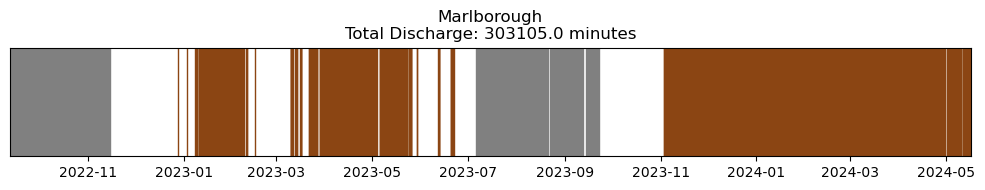

In [9]:
monitor = tw.active_monitors["Marlborough"]
monitor.plot_history()

Alternatively, we can get all of the discharge events in the form of a `pandas` dataframe using the `get_history_df()` method. This returns a dataframe that contains all the discharge events for all the monitors managed by the water company, sorted from newest to oldest start times. This dataframe can then be analysed using standard pandas methods. The columns of the dataframe are shown below:

In [10]:
df = tw.history_to_discharge_df()
print(df.columns.to_list())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing 15 Coldharbour Lane, Bushey
	Processing Abbess Roding
	Processing Abbey Mills
	Processing Abbeydale Road
	Processing Abingdon
	Processing Acton & Storm Works
	Processing Aldermaston
	Processing Aldershot Town
	Processing Alicia Avenue CSO
	Processing Allendale Road
	Processing Alperton Lane
	Processing Amersham Balancing Tanks/Amersham Vale STK
	Processing Ampney St Peter
	Processing Amyand Park Road, Twickenham
	Processing Andoversford
	Processing Appleton
	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton
	Processing Banbury
	Processing Banbury Rd Middleton Cheney
	Processing Bancroft Rugby Ground, Buckhurst Hill
	Processing Barbers Lane
	Process

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:429: UserWarning: !WARNING! Event is ongoing and has no end time. Returning None.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:922: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)


	Processing Chapmore End
	Processing Charlbury
	Processing Charlton Storm Relief
	Processing Charlton-On-Otmoor
	Processing Charlwood, Surrey
	Processing Chelsea, London, Sw10
	Processing Chertsey
	Processing Chesham
	Processing Chieveley
	Processing Chigwell Road / Langston Road
	Processing Chigwell Road, Woodford Green
	Processing Chingford Storm Tanks
	Processing Chinnor
	Processing Chipping Norton
	Processing Chipping Warden
	Processing Chisledon Storm Tanks 
	Processing Chobham
	Processing Cholsey
	Processing Church Hanborough
	Processing Church Hill Road, Barnet
	Processing Church Road
	Processing Church Road/Brent Lodge Park (Bunny Park)
	Processing Church Street KT13 8DP
	Processing Church Street Sewer
	Processing Churt
	Processing Cirencester
	Processing Clanfield
	Processing Clapham Storm Relief Sewer, London
	Processing Clifton
	Processing Cobham Bridge, Adj Cobham PS
	Processing Codicote
	Processing Colgate
	Processing Colin Crescent, Colindale
	Processing Combe
	Processing

This can then be saved to file using the standard Pandas methods. For example, to save it as a CSV file that can be analysed using other tools (e.g, Excel) we can do the following:

In [11]:
filename = tw.name + tw.history_timestamp.strftime("%y%m%d%H%M%S") + ".csv"
print(f"Saving history to {filename}")
df.to_csv(filename, header=True, index=False)

Saving history to ThamesWater240516161058.csv


Lets say we want to look at how CSO overflows have changed over time. Or perhaps how many monitors are online at any one time across a water companies patch. We can do this using the `get_monitor_timeseries()` method of a `WaterCompany`. This generates time series of the number of active CSOs, recently active CSOs and online monitors at 15 minute intervals (the approximate frequency of the data). Lets generate this data from the start of 2022.

In [12]:
since = datetime.datetime(2022, 1, 1)
monitor_series = tw.get_monitor_timeseries(since=since)

Processing (Northern) Low Level No 1 Brook Green
Processing 15 Coldharbour Lane, Bushey
Processing Abbess Roding
Processing Abbey Mills
Processing Abbeydale Road
Processing Abingdon
Processing Acton & Storm Works
Processing Aldermaston
Processing Aldershot Town
Processing Alicia Avenue CSO
Processing Allendale Road
Processing Alperton Lane
Processing Amersham Balancing Tanks/Amersham Vale STK
Processing Ampney St Peter
Processing Amyand Park Road, Twickenham
Monitor Amyand Park Road, Twickenham has no recorded events
Processing Andoversford
Processing Appleton
Processing Arborfield
Processing Arford
Processing Ascot
Processing Ash Ridge (Wokingham)
Processing Ash Vale
Processing Aston Le Walls
Processing Auckland Road Storm Tanks
Processing Avon Dassett
Processing Avondale Rd
Processing Aylesbury
Processing Bakers Farm, High Wych
Processing Bampton
Processing Banbury
Processing Banbury Rd Middleton Cheney
Processing Bancroft Rugby Ground, Buckhurst Hill
Processing Barbers Lane
Monitor 

Now lets plot the results.

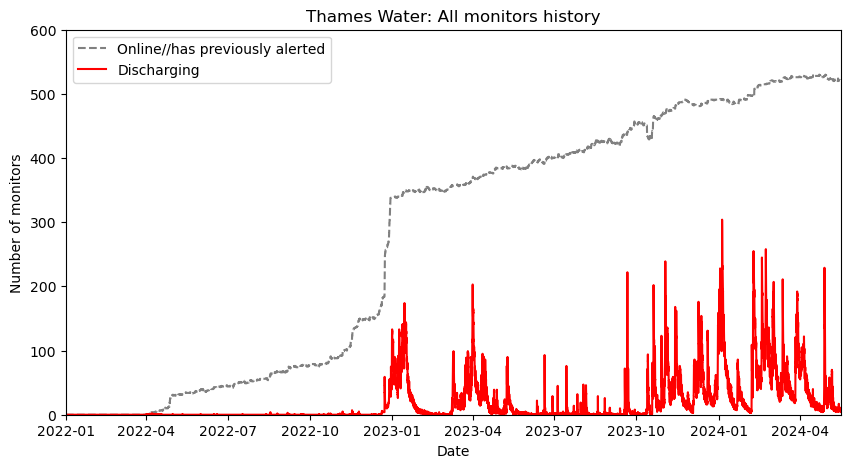

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online//has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_discharging"],
    c="red",
    label="Discharging",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Note that for "online" we conservatively assume that every monitor was _offline_ until we receive any positive event from it. This means that if a monitor is installed but recording    'NotDischarging' for a month until its first discharge event, it will be counted as offline for that month. Lacking any other information, this is the most conservative assumption we can make.  The first few monitors were attached to the API in April 2022, so the number of monitors "online" since then rises. But, in December '22/January '23 many more were hooked up and so the number of monitors "online" spikes. Since then, the coverage has got gradually better but the number of active monitors has remained fairly constant. It is therefore inappropriate to use this dataset to compare discharge histories between 2022 and 2023, as the number of active monitors has changed so much. You should use the annual returns for that instead. As expected there are more CSOs active during the winter months. To get a more averaged (less 'spiky') view of the data we can look at those which have been active in the last 48 hours (shown below) but the overall picture is the same.

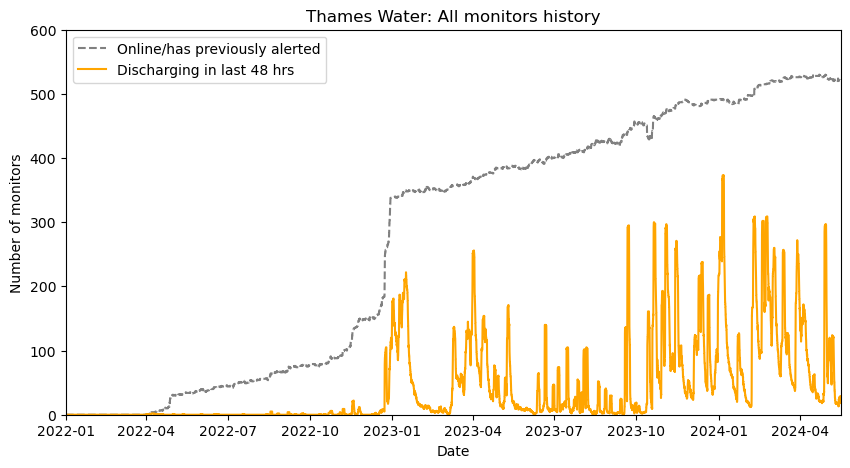

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online/has previously alerted",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_recently_discharging"],
    c="orange",
    label="Discharging in last 48 hrs",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 600)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Finally we can see how easy it is to generate some simple statistics about the data. For example:

In [15]:
number_online_now = monitor_series["number_online"].iloc[-1]
print(f"Number of monitors 'online' now: {number_online_now}")
number_discharging_now = monitor_series["number_discharging"].iloc[-1]
print(f"Number of monitors discharging now: {number_discharging_now}")
print(f"Proportion of monitors discharging now: {number_discharging_now / number_online_now * 100:.2f}%")
number_recently_discharging_now = monitor_series["number_recently_discharging"].iloc[-1]
print(f"Number of monitors discharging in last 48 hrs: {number_recently_discharging_now}")
print(f"Proportion of monitors discharging in last 48 hrs: {number_recently_discharging_now / number_online_now * 100:.2f}%")

Number of monitors 'online' now: 523
Number of monitors discharging now: 4
Proportion of monitors discharging now: 0.76%
Number of monitors discharging in last 48 hrs: 20
Proportion of monitors discharging in last 48 hrs: 3.82%
